# A jupyter notebook to transform Galaxy history into an RDF provenance graph using the PROV-O ontology

see also: https://usegalaxy.fr/api/docs 


In [1]:
from rdflib import Dataset, URIRef, Literal, BNode
import requests
import json
from tqdm.notebook import tqdm

from IPython.display import display, Markdown

from rdflib import Namespace
from rdflib.namespace import DCTERMS, OWL, RDF, RDFS, XMLNS, XSD

from datetime import datetime

PROV = Namespace("http://www.w3.org/ns/prov#")

# YOUR API KEY
# api_key = "a0184a05326258ba222783c6fb2949c4"
# galaxy_url = "https://usegalaxy.fr"

api_key = "b15041ec63cd53ad3e02f25cc3fa6781"
galaxy_url = "https://usegalaxy.eu"

http_params = {"key": api_key}
galaxy_hist_url = galaxy_url + "/api/histories"

tools_cache = {}

In [9]:
!pip install 'numpy<2' pandas faiss-cpu chainlit langchain langchain-groq rdflib 'sentence-transformers[torch]'

  Using cached numpy-1.26.4-cp312-cp312-macosx_10_9_x86_64.whl.metadata (61 kB)
  Using cached aiofiles-24.1.0-py3-none-any.whl.metadata (10 kB)
  Using cached filetype-1.2.0-py2.py3-none-any.whl.metadata (6.5 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nest_asyncio-1.6.0-py3-none-any.whl.metadata (2.8 kB)
  Using cached starlette-0.50.0-py3-none-any.whl.metadata (6.3 kB)
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of langchain-groq to determine which version is compatible with other requirements. This could take a while.
  Using cached langchain_groq-0.3.8-py3-none-any.whl.metadata (2.6 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 4.6 MB/s eta 0:00:00
  Using cached torch-2.2.2-cp312-none-macosx_10_9_x86_64.whl.metadata (25 kB)
  Using cached scikit_learn-1.8.0-cp312-cp312-macosx_10_13_x86_64.whl.metadata (11 kB)
  Using cached scipy-

In [2]:
def list_public_histories(url, key):
    """ """
    res = []
    r = requests.get(url + "/api/histories/published", params={"key": str(key)})
    print(r.text)
    print(r.json())
    histories = r.json()
    # if r.json().get('err_msg'):
    #    print(r.json()['err_msg'])
    #    return res

    for h in histories:
        if "2025-" in h["update_time"]:
            res.append((h["id"], h["name"], h["update_time"]))

    res = sorted(
        res,
        key=lambda x: datetime.fromisoformat(x[2].replace("Z", "+00:00")),
        reverse=True,
    )
    return res


def list_histories(url, key):
    """ """
    res = []
    r = requests.get(url + "/api/histories", params={"key": str(key)})
    print(r.text)
    print(r.json())
    histories = r.json()

    for h in histories:
        res.append((h["id"], h["name"], h["update_time"]))

    res = sorted(
        res,
        key=lambda x: datetime.fromisoformat(x[2].replace("Z", "+00:00")),
        reverse=True,
    )
    return res


def print_histories(url, key):
    """ """
    histories = list_public_histories(url, key)
    md = """
        | ID | NAME | UPDATE TIME |
        | ------ | ------ | ------ |
    """
    for h in histories:
        md += "| " + h[0] + " | " + h[1] + " | " + h[2] + " |\n"

    display(Markdown(md))


def fetch_EDAM_formats_mapping(url, key):
    r = requests.get(url + "/api/datatypes/edam_formats", params={"key": str(key)})
    return r.json()


def fetch_EDAM_data_mapping(url, key):
    r = requests.get(url + "/api/datatypes/edam_data", params={"key": str(key)})
    return r.json()

In [3]:
edam_formats = fetch_EDAM_formats_mapping(url=galaxy_url, key=api_key)
print(f"Fetched {len(edam_formats)} EDAM formats mappings")
print(json.dumps(edam_formats, indent=2))

edam_data = fetch_EDAM_data_mapping(url=galaxy_url, key=api_key)
print(f"Fetched {len(edam_data)} EDAM data mappings")
print(json.dumps(edam_data, indent=2))

Fetched 765 EDAM formats mappings
{
  "source.h": "format_2330",
  "source.c": "format_2330",
  "source.cpp": "format_2330",
  "source.py": "format_2330",
  "source.go": "format_2330",
  "source.rs": "format_2330",
  "source.cs": "format_2330",
  "markdown": "format_2330",
  "hep.root": "format_2333",
  "jp2": "format_2333",
  "ab1": "format_3000",
  "a2m": "format_1929",
  "afg": "format_3582",
  "agp": "format_3693",
  "anvio_cog_profile": "format_2331",
  "anvio_composite": "format_2331",
  "anvio_classifier": "format_1915",
  "anvio_contigs_db": "format_2331",
  "anvio_db": "format_2331",
  "anvio_genomes_db": "format_2331",
  "anvio_pan_db": "format_2331",
  "anvio_pfam_profile": "format_2331",
  "anvio_profile_db": "format_2331",
  "anvio_samples_db": "format_2331",
  "anvio_state": "format_3464",
  "anvio_structure_db": "format_2331",
  "anvio_variability": "format_3475",
  "arb": "format_2333",
  "arb.gz": "format_2333",
  "arff": "format_3581",
  "paf": "format_2330",
  "paf.g

In [15]:
import logging

logger = logging.getLogger()
logger.setLevel(logging.WARNING)


def gen_prov_graph_v2(url, key, hist_id):
    """ """
    G = Dataset()

    content_url = url + "/api/histories/" + hist_id + "/contents"

    # get the content of the history
    r = requests.get(content_url, params={"key": str(key)})
    content = r.json()

    for c in tqdm(content):
        content_id = c["id"]

        # get provenance from each history cell
        # print(f"requesting content {content_id} provenance")
        r = requests.get(
            content_url + "/" + content_id + "/provenance",
            params={"key": str(key)},
        )
        try:
            activity = r.json()
        except Exception as e:
            # print(e)
            logger.warning(
                f"Failed to get provenance for content {content_id}, {c['name']}: {e}"
            )
            # print(json.dumps(c, indent=2))
            continue

        job_id = activity["job_id"]
        tool_id = activity["tool_id"].strip(" ")
        params = activity["parameters"]

        ############
        # generating the activity
        G.add((URIRef(job_id), RDF.type, PROV.Activity))
        G.add((URIRef(job_id), PROV.wasAssociatedWith, URIRef(tool_id)))

        if tool_id:
            G.add((URIRef(tool_id), RDF.type, PROV.Agent))
            if tool_id not in tools_cache.keys():
                r = requests.get(
                    url + f"/api/tools/{tool_id}?io_details=true&link_details=true",
                    params={"key": str(key)},
                )
                tool_details = r.json()
                tools_cache[tool_id] = tool_details
            else:
                tool_details = tools_cache[tool_id]

            if "name" in tool_details.keys():
                if len(tool_details["name"]) > 0:
                    G.add((
                        URIRef(tool_id),
                        RDFS.label,
                        Literal(tool_details["name"]),
                    ))
            if "description" in tool_details.keys():
                if len(tool_details["description"]) > 0:
                    G.add((
                        URIRef(tool_id),
                        RDFS.comment,
                        Literal(tool_details["description"]),
                    ))
            if "xrefs" in tool_details.keys():
                for xref in tool_details["xrefs"]:
                    if xref.get("type") == "bio.tools":
                        G.add((
                            URIRef(tool_id),
                            OWL.sameAs,
                            URIRef(f"https://bio.tools/{xref['value']}"),
                        ))

            if "edam_operations" in tool_details.keys():
                for edam_op in tool_details["edam_operations"]:
                    G.add((
                        URIRef(tool_id),
                        URIRef("http://edamontology.org/has_operation"),
                        URIRef(f"http://edamontology.org/{edam_op}"),
                    ))
            if "edam_topics" in tool_details.keys():
                for edam_top in tool_details["edam_topics"]:
                    G.add((
                        URIRef(tool_id),
                        URIRef("http://edamontology.org/has_topic"),
                        URIRef(f"http://edamontology.org/{edam_top}"),
                    ))

        r = requests.get(url + "/api/jobs/" + job_id, params={"key": str(key)})
        job = r.json()
        if job.get("command_line"):
            # print(json.dumps(job, indent=True))
            # print(job["command_line"])
            G.add((
                URIRef(job_id),
                PROV.value,
                Literal(job["command_line"]),
            ))
        G.add((
            URIRef(job_id),
            PROV.startedAtTime,
            Literal(job["create_time"], datatype=XSD.dateTime),
        ))
        G.add((
            URIRef(job_id),
            PROV.endedAtTime,
            Literal(job["update_time"], datatype=XSD.dateTime),
        ))

        ############
        # generating the output
        G.add((URIRef(content_id), RDF.type, PROV.Entity))
        G.add((URIRef(content_id), PROV.wasGeneratedBy, URIRef(job_id)))
        G.add((URIRef(content_id), PROV.wasAttributedTo, URIRef(tool_id)))

        if c.get("name"):
            G.add((URIRef(content_id), RDFS.label, Literal(c["name"])))
        if c.get("url"):
            G.add((URIRef(content_id), RDFS.seeAlso, Literal(c["url"])))
        if c.get("dataset_id"):
            d_id = c.get("dataset_id")
            r2 = requests.get(url + "/api/datasets/" + d_id, params={"key": str(key)})
            dataset = r2.json()

        # adding EDAM format & data
        if c.get("extension"):
            file_ext = c["extension"]
            # print("extension:", c["extension"])
            if file_ext in edam_formats.keys():
                edam_format_value = edam_formats[file_ext]
                G.add((
                    URIRef(content_id),
                    URIRef("http://edamontology.org/has_format"),
                    URIRef(f"http://edamontology.org/{edam_format_value}"),
                ))
            else:
                print(f"No EDAM format mapping for extension: {file_ext}")

            if file_ext in edam_data.keys():
                edam_data_value = edam_data[file_ext]
                G.add((
                    URIRef(content_id),
                    URIRef("http://edamontology.org/has_data"),
                    URIRef(f"http://edamontology.org/{edam_data_value}"),
                ))
            else:
                print(f"No EDAM data mapping for extension: {file_ext}")

        ############
        # generating the inputs
        for k in params.keys():
            if "input" in k:
                if isinstance(params[k], dict) and params[k].get("id"):
                    input_id = params[k]["id"]
                    r = requests.get(
                        url + "/api/datasets/" + input_id,
                        params={"key": str(key)},
                    )
                    in_dataset = r.json()

                    G.add((URIRef(input_id), RDF.type, PROV.Entity))
                    if in_dataset.get("name"):
                        G.add((
                            URIRef(input_id),
                            RDFS.label,
                            Literal(in_dataset["name"]),
                        ))
                    if in_dataset.get("url"):
                        G.add((
                            URIRef(input_id),
                            RDFS.seeAlso,
                            Literal(in_dataset["download_url"]),
                        ))

                    # adding EDAM format & data
                    if in_dataset.get("extension"):
                        file_ext = in_dataset["extension"]
                        if file_ext in edam_formats.keys():
                            edam_format_value = edam_formats[file_ext]
                            G.add((
                                URIRef(input_id),
                                URIRef("http://edamontology.org/has_format"),
                                URIRef(f"http://edamontology.org/{edam_format_value}"),
                            ))
                        else:
                            print(f"No EDAM format mapping for extension: {file_ext}")

                        if file_ext in edam_data.keys():
                            edam_data_value = edam_data[file_ext]
                            G.add((
                                URIRef(input_id),
                                URIRef("http://edamontology.org/has_data"),
                                URIRef(f"http://edamontology.org/{edam_data_value}"),
                            ))
                        else:
                            print(f"No EDAM data mapping for extension: {file_ext}")

                    G.add((URIRef(job_id), PROV.used, URIRef(input_id)))
                    G.add((
                        URIRef(content_id),
                        PROV.wasDerivedFrom,
                        URIRef(input_id),
                    ))
    return G

In [5]:
# %%time
# print_histories(galaxy_url, api_key)
histories = list_public_histories(galaxy_url, api_key)


[{"model_class":"History","id":"11ac94870d0bb33a7d017abe6132889b","name":"Unnamed history","deleted":false,"purged":false,"archived":false,"url":"/api/histories/11ac94870d0bb33a7d017abe6132889b","published":true,"count":4,"annotation":null,"tags":[],"update_time":"2026-01-07T23:20:12.420866","preferred_object_store_id":null},{"model_class":"History","id":"11ac94870d0bb33aa9c7c1c7915d0915","name":"IHPE control 2026","deleted":false,"purged":false,"archived":false,"url":"/api/histories/11ac94870d0bb33aa9c7c1c7915d0915","published":true,"count":97,"annotation":null,"tags":[],"update_time":"2026-01-07T16:08:10.309844","preferred_object_store_id":null},{"model_class":"History","id":"11ac94870d0bb33ad0b2377559b8ca44","name":"Bacterial genome + RNA-seq mapping project","deleted":false,"purged":false,"archived":false,"url":"/api/histories/11ac94870d0bb33ad0b2377559b8ca44","published":true,"count":21,"annotation":null,"tags":[],"update_time":"2026-01-07T10:13:06.266445","preferred_object_store_

In [6]:
print(f"Found {len(histories)} public histories")

for h in histories[:30]:
    history_name_nospace = h[1].replace(" ", "_").replace("/", "_").replace("'", "")
    print(f"[{h[2]}] History {h[0]}: {history_name_nospace}")

Found 1796 public histories
[2025-12-31T21:28:54.391623] History 11ac94870d0bb33aa7476ddf3550fa42: Attempt_4
[2025-12-31T17:23:52.790860] History b07a400eb4d143f3: BAL_Cells_DIA_Data_EncyclopeDIA
[2025-12-31T02:36:43.033822] History 95019310fa1c60a1: Workshop
[2025-12-30T15:44:04.998610] History 11ac94870d0bb33a3a8e05c82d7c8eb5: Tarea_Tema_5
[2025-12-30T14:00:22.969437] History 11ac94870d0bb33a72c10ba0aac867a9: WGS@_Genome_in_a_Bottle_HG004_NA24143_mother_cont>take_-_+50Kb_of_PGx_genes_of_PharmVIP
[2025-12-29T17:50:24.631881] History 4a11b893801a9dea: Aug20_EncyclopeDIA_raw_outputs_-_BALCells_DIA
[2025-12-29T17:45:58.628114] History 76878b346d1a0010: Outputs_PROBE_DIA_07152024
[2025-12-28T16:33:16.526872] History 11ac94870d0bb33a5f86590630f76908: Copy_of_Scribe_M111_M50_M100
[2025-12-28T13:05:15.981189] History 11ac94870d0bb33a8a94043514b6b66a: GTN_Reference-based_RNA-seq_Part_1
[2025-12-28T11:37:45.449052] History 11ac94870d0bb33a6800b37bbb573472: Analysis_of_differentially_expressed_

In [16]:
%%time
# graph = gen_prov_graph_v2(galaxy_url, api_key, "50b6ae34a811c9ba")

graph = gen_prov_graph_v2(galaxy_url, api_key, "11ac94870d0bb33a76b5f0b7b347b500")
graph.serialize(destination="Labaratorinis_1_antagomiR.ttl", format="turtle")

# graph = gen_prov_graph_v2(galaxy_url, api_key, "9ab43c28dc8dfe2a")

#graph = gen_prov_graph_v2(galaxy_url, api_key, "e42801c065f09977")
#graph.serialize(destination="MetaG_extended.ttl", format="turtle")


  0%|          | 0/124 [00:00<?, ?it/s]

Failed to get provenance for content fdf557dfb5a5fc3f, Pair-end data (fasterq-dump): Expecting value: line 1 column 1 (char 0)
Failed to get provenance for content e8bb400d28039a35, Single-end data (fasterq-dump): Expecting value: line 1 column 1 (char 0)
Failed to get provenance for content 04d754aabb20fcd9, Other data (fasterq-dump): Expecting value: line 1 column 1 (char 0)
Failed to get provenance for content 52b23868b64cf586, Falco on collection 3: Webpage: Expecting value: line 1 column 1 (char 0)
Failed to get provenance for content 52abbaf1522e6017, Falco on collection 3: RawData: Expecting value: line 1 column 1 (char 0)
Failed to get provenance for content b3f0cd7b821855db, Falco on collection 3: SummaryData: Expecting value: line 1 column 1 (char 0)
Failed to get provenance for content f32f793dd2f429b1, HISAT2 on collection 3: aligned reads (BAM): Expecting value: line 1 column 1 (char 0)
Failed to get provenance for content 6b5e1f497ba68a66, HISAT2 on collection 3: Mapping 

CPU times: user 3.31 s, sys: 749 ms, total: 4.05 s
Wall time: 1min 30s


<Graph identifier=Nf14a0e1e3ec74710af4f722e4fa92976 (<class 'rdflib.graph.Dataset'>)>

# Linking tools with Bio.Tools and retrieving EDAM terms

In [33]:
from rdflib import Graph
from sentence_transformers import SentenceTransformer
import pandas as pd

import faiss
import numpy as np

biotools_graph = Graph()
biotools_graph.parse("./bioschemas-dump.ttl", format="ttl")


def gen_biotools_table():
    q = """
    PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
    PREFIX owl: <http://www.w3.org/2002/07/owl#>
    PREFIX biotools: <https://bio.tools/ontology/> 
    PREFIX bsc: <http://bioschemas.org/> 
    PREFIX bsct: <http://bioschemas.org/types/> 
    PREFIX dcterms: <http://purl.org/dc/terms/> 
    PREFIX edam: <http://edamontology.org/> 
    PREFIX sc: <http://schema.org/> 

    SELECT ?tool_id ?name ?desc WHERE {
        ?tool_id a sc:SoftwareApplication ; 
            sc:description ?desc ;
            sc:name ?name .
    }
    """
    res = biotools_graph.query(q)
    rows = []
    for row in res:
        rows.append({
            "Tool ID": str(row["tool_id"]),
            "Name": str(row["name"]) if row["name"] else "",
            "Description": str(row["desc"]) if row["desc"] else "",
        })
    df = pd.DataFrame(rows)
    # return df.head(20000)  # Limit to 10000 rows for performance
    return df

def gen_full_desc(row):
    ## Generate a full description of the ontology class
    ## TODO take into account inherited definitions from parents
    full_desc = f"""{row["Name"]}: {row["Description"]}"""
    return full_desc


df = gen_biotools_table()
df["full_desc"] = df.apply(gen_full_desc, axis=1)
# print(f"Number of HPO terms: {len(df)}")
print(df["full_desc"].iloc[0])
print(df["full_desc"].iloc[1])

# sys.exit(0)

## Embeddings
encoder = SentenceTransformer("all-MiniLM-L6-v2")

# if hpo_faiss.index exists, load it
try:
    index = faiss.read_index("biotools_faiss.index")
    print("Index loaded from disk")
except:
    print("Index not found, creating a new one")

    vectors = encoder.encode(df["full_desc"])
    print(f"Number of biotools entries: {len(vectors)}")
    print(f"Vectors shape: {vectors.shape}")
    ## Indexing
    vector_dimension = vectors.shape[1]

    #faiss.normalize_L2(vectors)
    #index = faiss.IndexFlatIP(vector_dimension)

    index = faiss.IndexFlatL2(vector_dimension)
    index.add(vectors)

    ## serialize the index to disk
    print("Saving index to disk...")
    faiss.write_index(index, "biotools_faiss.index")
    print("Index saved.")


indexes = {}
split_classes = {}

print("Setup complete.")
print("Available biotools entries: ", indexes.keys())


def retrieve_from_biotools(question: str, k=10) -> str:
    search_vector = encoder.encode(question)
    _vector = np.array([search_vector])

    # top-K :
    distances, ann = index.search(_vector, k=k)

    #print(f"Distances: {distances}")
    #print(f"ANN: {ann}")

    dist_df = pd.DataFrame({
        "Distance": pd.Series(distances[0]).apply(lambda x: round(x, 2)),
        "ann": ann[0],
    })

    # join by: dfl.ann = data.index
    top_k = pd.merge(dist_df, df, left_on="ann", right_index=True)

    return top_k[["Name", "Distance", "Tool ID"]]

1000Genomes: The 1000 Genomes Project ran between 2008 and 2015, creating a deep catalogue of human genetic variation. The International Genome Sample Resource (IGSR) was set up to ensure the future usability and accessibility of this data.
1000Genomes assembly converter: Map your data to the current assembly.
Index loaded from disk
Setup complete.
Available biotools entries:  dict_keys([])


In [34]:
retrieve_from_biotools("gtftobed12", k=3)

Name  Distance                          Tool ID
0  gtftogenepred      1.14  https://bio.tools/gtftogenepred
1      gtpbinder      1.28      https://bio.tools/gtpbinder
2      GTXplorer      1.28      https://bio.tools/gtxplorer

In [44]:
# get operation for specific tool
def get_tool_operations(tool_uri: str):
    q = f"""
    PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
    PREFIX owl: <http://www.w3.org/2002/07/owl#>
    PREFIX biotools: <https://bio.tools/ontology/> 
    PREFIX bsc: <http://bioschemas.org/> 
    PREFIX bsct: <http://bioschemas.org/types/> 
    PREFIX dcterms: <http://purl.org/dc/terms/> 
    PREFIX edam: <http://edamontology.org/> 
    PREFIX sc: <http://schema.org/> 

    SELECT ?operation WHERE {{
        <{tool_uri}> sc:featureList ?operation .
    }}
    """
    res = biotools_graph.query(q)
    operations = []
    for row in res:
        operations.append(str(row["operation"]))
    return operations

# list all software
q = """
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX biotools: <https://bio.tools/ontology/> 
PREFIX bsc: <http://bioschemas.org/> 
PREFIX bsct: <http://bioschemas.org/types/> 
PREFIX dcterms: <http://purl.org/dc/terms/> 
PREFIX edam: <http://edamontology.org/> 
PREFIX sc: <http://schema.org/>

SELECT ?tool_id ?name ?desc WHERE {
    ?tool_id a prov:Agent .
    OPTIONAL { ?tool_id rdfs:comment ?desc } .
    ?tool_id rdfs:label ?name .

    # only tools without edam:has_operation
    FILTER NOT EXISTS {
        ?tool_id <http://edamontology.org/has_operation> ?op . 
    }
}
"""
g2 = Graph().parse("./Labaratorinis_1_antagomiR.ttl", format="ttl")
res = g2.query(q)
for row in res:
    if row['desc']:
        print(f"{row['name']}: {row['desc']}")
        tool_uri = retrieve_from_biotools(row['name'], k=1)["Tool ID"].values[0]
        distance = retrieve_from_biotools(row['name'], k=1)["Distance"].values[0]
        if distance > 1.0:
            print("High distance, skipping operation retrieval.")
            continue
        print(f"Matched to Bio.Tools: {tool_uri}")
        print(f"Distance: {distance}")
        operations = get_tool_operations(tool_uri)
        print(f"Operations: {operations}")
        # update the graph with the operations
        for op in operations:
            g2.add((
                row['tool_id'],
                URIRef("http://edamontology.org/has_operation"),
                URIRef(op),
            ))
    else:
        print(f"{row['name']}")
        tool_uri = retrieve_from_biotools(row['name'], k=1)["Tool ID"].values[0]
        distance = retrieve_from_biotools(row['name'], k=1)["Distance"].values[0]
        if distance > 1.0:
            print("High distance, skipping operation retrieval.")
            continue
        print(f"Matched to Bio.Tools: {tool_uri}")
        print(f"Distance: {distance}")
        operations = get_tool_operations(tool_uri)
        print(f"Operations: {operations}")
        for op in operations:
            g2.add((
                row['tool_id'],
                URIRef("http://edamontology.org/has_operation"),
                URIRef(op),
            ))
# serialize the updated graph
g2.serialize(destination="Labaratorinis_1_antagomiR_enriched.ttl", format="turtle")

Convert compressed file to uncompressed.
Matched to Bio.Tools: https://bio.tools/extract_archive_merge
Distance: 0.89
Operations: ['http://edamontology.org/operation_0335', 'http://edamontology.org/operation_3436']
Column join: on multiple datasets
High distance, skipping operation retrieval.
Convert GTF to BED12
Matched to Bio.Tools: https://bio.tools/gtftogenepred
Distance: 1.0
Operations: ['http://edamontology.org/operation_3267']


<Graph identifier=Nb6d82b0e680c450fba559a1925affa9f (<class 'rdflib.graph.Graph'>)>

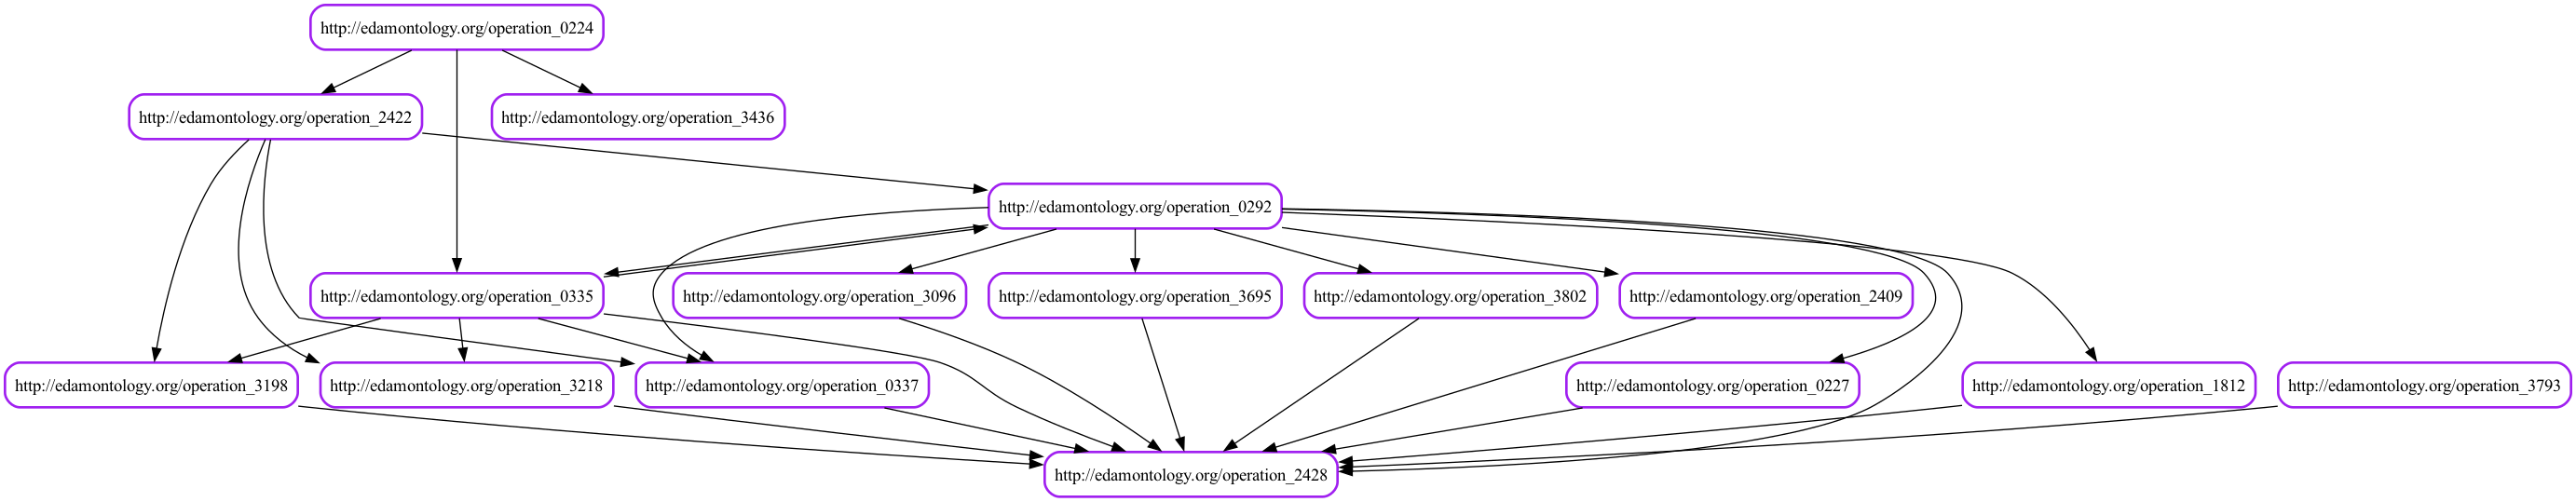

<Graph identifier=N45d9305e288d4662802baaca2aa550f7 (<class 'rdflib.graph.Graph'>)>

In [49]:
import pygraphviz as pgv
from IPython.display import Image

def draw(dot):
    return Image(pgv.AGraph(dot).draw(format="png", prog="dot"))

operations_dependency_graph_query = """
PREFIX prov: <http://www.w3.org/ns/prov#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

CONSTRUCT {
    ?edam_op1 rdfs:label ?op1_label .
    ?edam_op1 rdfs:comment ?cmd1 .
    ?edam_op2 rdfs:label ?op2_label .
    ?edam_op2 rdfs:comment ?cmd2 .
    ?edam_op2 <http://sharefair/is_after> ?edam_op1
} WHERE {
    ?d2 prov:wasGeneratedBy ?a2 .
    ?a2 prov:value ?cmd2 .
    ?a2 prov:wasAssociatedWith ?tool2 .
    ?tool2 <http://edamontology.org/has_operation> ?edam_op2 .
    
    ?a2 prov:used ?d1 .
    
    ?d1 prov:wasGeneratedBy ?a1 .
    ?a1 prov:value ?cmd1 .
    ?a1 prov:wasAssociatedWith ?tool1 .
    ?tool1 <http://edamontology.org/has_operation> ?edam_op1 .
}
"""

g2.parse("EDAM_1.25.ttl", format="turtle")
summary = g2.query(operations_dependency_graph_query).graph
# print(summary.serialize(format="turtle"))

G_op = pgv.AGraph(directed=True)

for s, p, o in summary.triples((None, URIRef("http://sharefair/is_after"), None)):
    o1 = get_short_label(str(s))
    o2 = get_short_label(str(o))
    G_op.add_node(o1, shape="box", style="rounded, bold", color="purple")
    G_op.add_node(o2, shape="box", style="rounded, bold", color="purple")
    G_op.add_edge(o2, o1)

display(Image(G_op.draw(format="png", prog="dot")))
# save the immage
G_op.draw("operations_dependency_graph.pdf", format="pdf", prog="dot")
# save the summary graph
summary.serialize(destination="operations_dependency_graph.ttl", format="turtle")

In [205]:
graph.parse("EDAM_1.25.ttl", format="turtle")

<Graph identifier=urn:x-rdflib:default (<class 'rdflib.graph.Graph'>)>

In [47]:
def get_short_label(identifier):
    res = []
    for s1, p1, label in graph.triples((URIRef(identifier), RDFS.label, None)):
        res.append(str(label))
    short = ""
    if len(res) > 0:
        short = res[0]
    for r in res:
        if len(r) < len(short):
            short = r

    if len(short) == 0:
        return identifier
    else:
        return short


def get_associated_tool(identifier):
    res = []
    for s, p, tool in graph.triples((URIRef(identifier), PROV.wasAssociatedWith, None)):
        res.append(str(tool))

    if len(res) > 1:
        print(f"WARN more than one tool associated to an execution {identifier}")
        return None
    elif len(res) == 1:
        return res[0]
    else:
        print(f"WARN no tools associated to execution {identifier}")

In [207]:
import pygraphviz as pgv
from IPython.display import Image


def draw(dot):
    return Image(pgv.AGraph(dot).draw(format="png", prog="dot"))

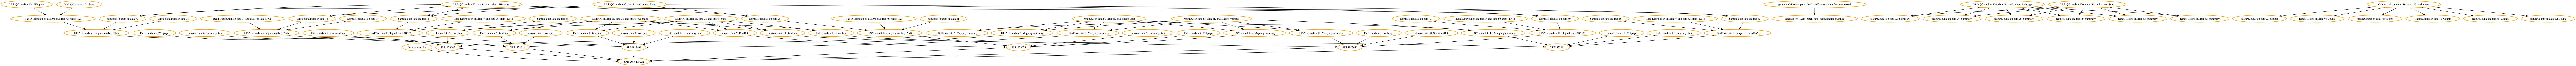

In [208]:
G = pgv.AGraph(directed=True)

for s, p, o in graph.triples((None, PROV.wasDerivedFrom, None)):
    d1 = get_short_label(str(o))
    d2 = get_short_label(str(s))
    G.add_node(d1, shape="ellipse", style="bold", color="orange")
    G.add_node(d2, shape="ellipse", style="bold", color="orange")
    G.add_edge(d2, d1)

display(Image(G.draw(format="png", prog="dot")))

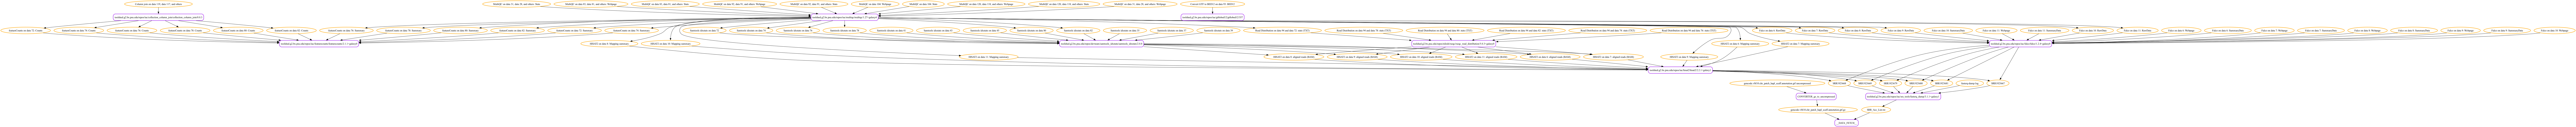

In [209]:
G = pgv.AGraph(directed=True)

for s, p, o in graph.triples((None, PROV.used, None)):
    tool = get_associated_tool(str(s))
    data = get_short_label(str(o))
    G.add_node(data, shape="ellipse", style="bold", color="orange")
    G.add_node(tool, shape="box", style="rounded, bold", color="purple")
    G.add_edge(tool, data)

for s, p, o in graph.triples((None, PROV.wasGeneratedBy, None)):
    tool = get_associated_tool(str(o))
    data = get_short_label(str(s))
    G.add_node(tool, shape="box", style="rounded, bold", color="purple")
    G.add_node(data, shape="ellipse", style="bold", color="orange")
    G.add_edge(data, tool)

display(Image(G.draw(format="png", prog="dot")))

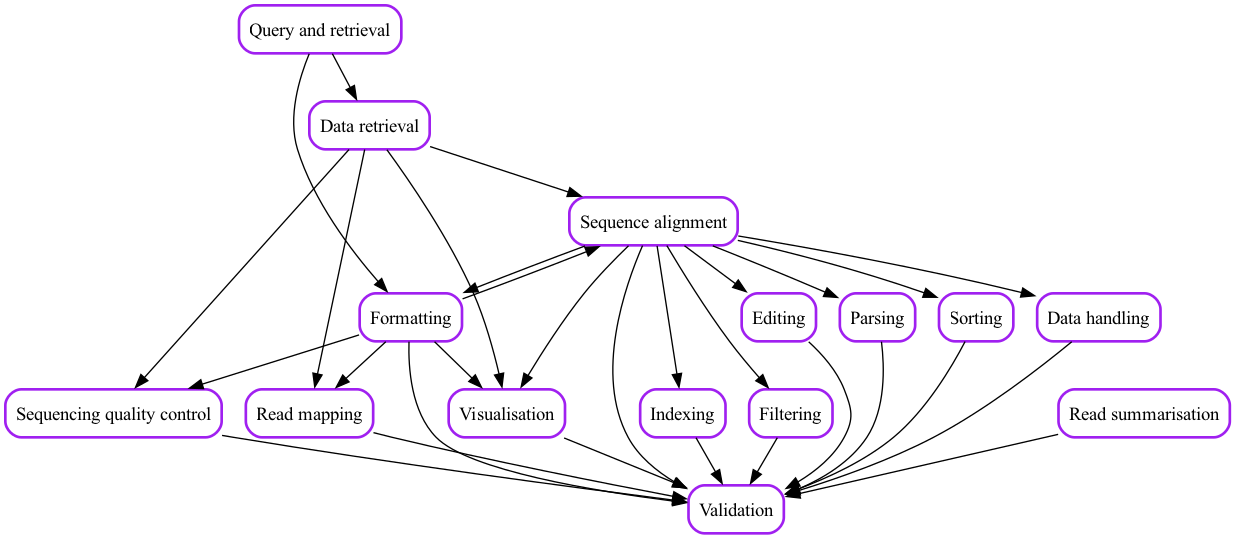

<Graph identifier=Na2018d472af0420ea33b80714ea6ce58 (<class 'rdflib.graph.Graph'>)>

In [210]:
operations_dependency_graph_query = """
PREFIX prov: <http://www.w3.org/ns/prov#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

CONSTRUCT {
    ?edam_op1 rdfs:label ?op1_label .
    ?edam_op1 rdfs:comment ?cmd1 .
    ?edam_op2 rdfs:label ?op2_label .
    ?edam_op2 rdfs:comment ?cmd2 .
    ?edam_op2 <http://sharefair/is_after> ?edam_op1
} WHERE {
    ?d2 prov:wasGeneratedBy ?a2 .
    ?a2 prov:value ?cmd2 .
    ?a2 prov:wasAssociatedWith ?tool2 .
    ?tool2 <http://edamontology.org/has_operation> ?edam_op2 .
    
    ?a2 prov:used ?d1 .
    
    ?d1 prov:wasGeneratedBy ?a1 .
    ?a1 prov:value ?cmd1 .
    ?a1 prov:wasAssociatedWith ?tool1 .
    ?tool1 <http://edamontology.org/has_operation> ?edam_op1 .
}
"""

summary = graph.query(operations_dependency_graph_query).graph
# print(summary.serialize(format="turtle"))

G2 = pgv.AGraph(directed=True)

for s, p, o in summary.triples((None, URIRef("http://sharefair/is_after"), None)):
    o1 = get_short_label(str(s))
    o2 = get_short_label(str(o))
    G2.add_node(o1, shape="box", style="rounded, bold", color="purple")
    G2.add_node(o2, shape="box", style="rounded, bold", color="purple")
    G2.add_edge(o2, o1)

# for s, p, o in summary.triples((None, RDFS.comment, None)):
#    G2.add_node(str(s), shape="box", style="rounded, bold", color="purple")
#    G2.add_node(str(o), shape="ellipse", style="bold", color="orange")
#    G2.add_edge(str(s), str(o))

display(Image(G2.draw(format="png", prog="dot")))
# save the immage
G2.draw("operations_dependency_graph.pdf", format="pdf", prog="dot")
# save the summary graph
summary.serialize(destination="operations_dependency_graph.ttl", format="turtle")

In [211]:
## Verbalising all data processing activities
data_processing_query = """
PREFIX prov: <http://www.w3.org/ns/prov#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX owl: <http://www.w3.org/2002/07/owl#>

SELECT * WHERE {
    ?output prov:wasGeneratedBy ?activity .
    ?output rdfs:label ?output_label .
    OPTIONAL {?activity prov:value ?cmd} .
    ?activity prov:wasAssociatedWith ?tool .
    OPTIONAL {?tool <http://edamontology.org/has_operation> ?edam_op} .
    OPTIONAL {?tool owl:sameAs ?bio_tools_id} .
    
    ?activity prov:used ?input .
    ?input rdfs:label ?input_label .
}
"""

reporting_template = """
The data item <{output}> was generated by the activity <{activity}>, which used the data item <{input}>.
The activity was associated with the tool <{tool}>, registered in bio.tools with the <{bio_tools_id}> ID.
The command used was: "{cmd}".
The EDAM operation associated with the tool was: <{edam_op}>."
"""

res = graph.query(data_processing_query)
for row in res:
    print(
        reporting_template.format(
            output=row["output_label"],
            activity=row["activity"],
            input=row["input_label"],
            tool=row["tool"],
            bio_tools_id=row["bio_tools_id"] if row["bio_tools_id"] else "N/A",
            cmd=row["cmd"] if row["cmd"] else "N/A",
            edam_op=row["edam_op"] if row["edam_op"] else "N/A",
        )
    )
    print("----")


The data item <fasterq-dump log> was generated by the activity <11ac94870d0bb33a03a93f9ae7afe8b0>, which used the data item <SRR_Acc_List.txt>.
The activity was associated with the tool <toolshed.g2.bx.psu.edu/repos/iuc/sra_tools/fasterq_dump/3.1.1+galaxy1>, registered in bio.tools with the <https://bio.tools/sra-tools> ID.
The command used was: "set -o | grep -q pipefail && set -o pipefail;  mkdir -p ~/.ncbi && cp '/data/jwd08/main/093/955/93955868/configs/tmpdz7vd90q' ~/.ncbi/user-settings.mkfg &&   export SRA_PREFETCH_RETRIES=3 && export SRA_PREFETCH_ATTEMPT=1 &&    grep '^[[:space:]]*[E|S|D]RR[0-9]\{1,\}[[:space:]]*$' '/data/dnb12/galaxy_db/files/d/9/2/dataset_d92c079e-be94-4444-b977-04bb90c28cbf.dat' > accessions && for acc in $(cat ./accessions); do ( echo "Downloading accession: $acc..." &&  while [ $SRA_PREFETCH_ATTEMPT -le $SRA_PREFETCH_RETRIES ] ; do fasterq-dump "$acc" -e ${GALAXY_SLOTS:-1} -t ${TMPDIR} --seq-defline '@$ac.$sn/$ri' --qual-defline '+' --split-3 --skip-techni